In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import gurobipy

import robust_value_approx.relu_system as relu_system
import robust_value_approx.lyapunov as lyapunov
import robust_value_approx.pybullet_data as pybullet_data

import robust_value_approx.test.train_2d_lyapunov_utils as train_2d_lyapunov_utils
import robust_value_approx.latent_system as latent_system

In [65]:
# data
urdf = 'pendulum.urdf'
dtype = torch.float64
pybullet_x_lo = torch.tensor([-np.pi/2, -1.], dtype=dtype)
pybullet_x_up = torch.tensor([np.pi/2, 1.], dtype=dtype)
dt = .2
grayscale = True
grayscale_weight = [.2989, .5870, .1140]
image_width = 48
image_height = 48

# training
num_samples = 1000
validation_ratio = .2
batch_size = 30
dyn_loss_weight = 1.
lyap_loss_weight = 10.
num_epoch = 10

# encoder-decoder
use_conv = False
z_dim = 3
z_lo = -10. * torch.ones(z_dim, dtype=dtype)
z_up = 10. * torch.ones(z_dim, dtype=dtype)

# dynamics nn
# dyn_nn_width = 30
dyn_nn_width = 10
dyn_nn_depth = 1

# lyapunov nn
# lyap_nn_width = 30
lyap_nn_width = 10
lyap_nn_depth = 1

In [10]:
pbsg = pybullet_data.PybulletSampleGenerator(urdf, image_width=image_width, image_height=image_height)

In [11]:
x_data, x_next_data, X_data, X_next_data = pbsg.generate_dataset(pybullet_x_lo, pybullet_x_up, dt, num_samples)

x_data = x_data.type(dtype)
x_next_data = x_next_data.type(dtype)
X_data = X_data.type(dtype)
X_next_data = X_next_data.type(dtype)

if grayscale:
    X_data_gray = torch.zeros(X_data.shape[0], 2, X_data.shape[2], X_data.shape[3], dtype=dtype)
    X_data_gray[:, 0, :, :] = grayscale_weight[0] * X_data[:, 0, :, :] + grayscale_weight[1] * X_data[:, 1, :, :] + grayscale_weight[2] * X_data[:, 2, :, :]
    X_data_gray[:, 1, :, :] = grayscale_weight[0] * X_data[:, 3, :, :] + grayscale_weight[1] * X_data[:, 4, :, :] + grayscale_weight[2] * X_data[:, 5, :, :]
    X_next_data_gray = torch.zeros(X_next_data.shape[0], 1, X_next_data.shape[2], X_next_data.shape[3], dtype=dtype)
    X_next_data_gray[:, 0, :, :] = grayscale_weight[0] * X_next_data[:, 0, :, :] + grayscale_weight[1] * X_next_data[:, 1, :, :] + grayscale_weight[2] * X_next_data[:, 2, :, :]
    X_data = X_data_gray
    X_next_data = X_next_data_gray

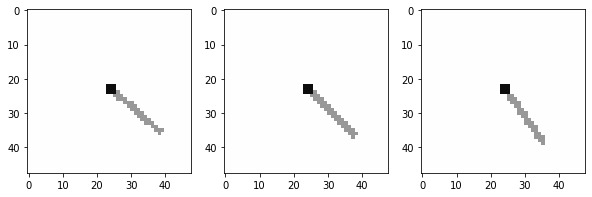

In [17]:
i = np.random.choice(X_data.shape[0], 1)[0]
pybullet_data.show_sample(X_data[i,:], X_next_data[i,:])

In [18]:
dyn_nn_layers = [torch.nn.Linear(z_dim, dyn_nn_width), torch.nn.ReLU()]
for i in range(dyn_nn_depth):
    dyn_nn_layers += [torch.nn.Linear(dyn_nn_width, dyn_nn_width), torch.nn.ReLU()]
dyn_nn_layers += [torch.nn.Linear(dyn_nn_width, z_dim)]
dyn_nn_model = torch.nn.Sequential(*dyn_nn_layers).type(dtype)

lyap_nn_layers = [torch.nn.Linear(z_dim, lyap_nn_width), torch.nn.ReLU()]
for i in range(lyap_nn_depth):
    lyap_nn_layers += [torch.nn.Linear(lyap_nn_width, lyap_nn_width), torch.nn.ReLU()]
lyap_nn_layers += [torch.nn.Linear(lyap_nn_width, 1)]
lyap_nn_model = torch.nn.Sequential(*lyap_nn_layers).type(dtype)

## Learning in image space

In [54]:
X_dataset = TensorDataset(X_data.double(), X_next_data.double())
# X_dataset = TensorDataset(X_data[:5,:].double(), X_next_data[:5,:].double())

train_size = int((1. - validation_ratio) * len(X_dataset))
test_size = len(X_dataset) - train_size
train_dataset_img, validation_dataset_img = torch.utils.data.random_split(X_dataset, [train_size, test_size])
train_dataloader_img = DataLoader(
    train_dataset_img,
    batch_size=batch_size,
)
validation_dataloader_img = DataLoader(
    validation_dataset_img,
    batch_size=len(validation_dataset_img),
)
validation_data_img = validation_dataloader_img.__iter__().next()

In [55]:
relu_sys = relu_system.AutonomousReLUSystem(dtype, z_lo, z_up, dyn_nn_model)
lyap = lyapunov.LyapunovDiscreteTimeHybridSystem(relu_sys, lyap_nn_model)
latent_sys = latent_system.LatentAutonomousReLUSystem(relu_sys, lyap, use_conv=use_conv, image_width=image_width, image_height=image_height, grayscale=grayscale)

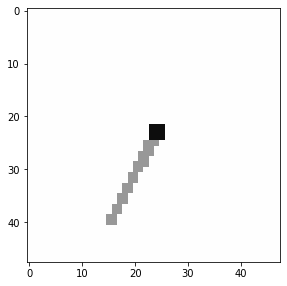

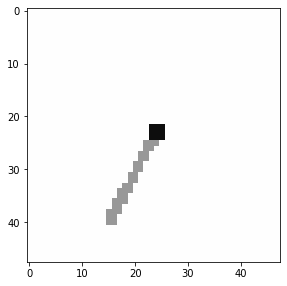

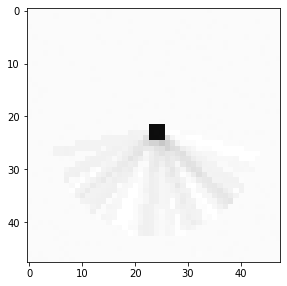

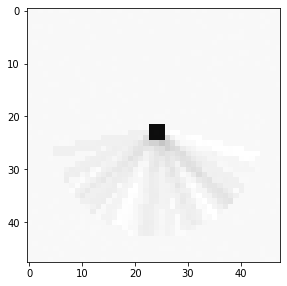

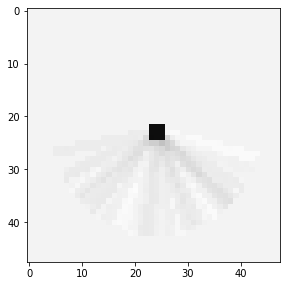

In [67]:
x_traj = latent_sys.rollout(X_data[0, :], 3, clamp=True)
for n in range(x_traj.shape[0]):
    pybullet_data.show_sample(x_traj[n, :], clamp=True)

In [57]:
optimizer = torch.optim.Adam([{'params': latent_sys.encoder.parameters()},
                              {'params': latent_sys.decoder.parameters()},
                              {'params': latent_sys.lyapunov.lyapunov_relu.parameters()}])

writer = SummaryWriter()
n_iter = 0

In [58]:
x_decoded, x_next_pred_decoded, z_mu, z_log_var = latent_sys.vae_forward(X_data[:3,:])
dyn_loss = latent_sys.vae_loss(X_data[:3,:], X_next_data[:3,:], x_decoded, x_next_pred_decoded, z_mu, z_log_var)
dyn_loss

tensor(128270.7100, dtype=torch.float64, grad_fn=<AddBackward0>)

In [66]:
for epoch_i in range(100):
    for x, x_next in train_dataloader_img:
        optimizer.zero_grad()
        
        if dyn_loss_weight > 0:
            x_decoded, x_next_pred_decoded, z_mu, z_log_var = latent_sys.vae_forward(x)
            dyn_loss = latent_sys.vae_loss(x, x_next, x_decoded, x_next_pred_decoded, z_mu, z_log_var)
        else:
            dyn_loss = torch.tensor(0., dtype=latent_sys.dtype)
        
        if lyap_loss_weight > 0:
            lyap_loss = latent_sys.lyapunov_loss()
        else:
            lyap_loss = torch.tensor(0., dtype=latent_sys.dtype)
        
        loss = dyn_loss_weight * dyn_loss + lyap_loss_weight * lyap_loss
        
#         print(dyn_loss_weight * dyn_loss)
#         print(lyap_loss_weight * lyap_loss)
#         print(loss)
#         print("---")
        
        loss.backward()
        optimizer.step()
        
        writer.add_scalar('Dynamics/train', dyn_loss_weight * dyn_loss.item(), n_iter)
        writer.add_scalar('Lyapunov', lyap_loss_weight * lyap_loss.item(), n_iter)
        n_iter += 1
      
#     with torch.no_grad():
#         validation_loss = dynamics_loss(dyn_nn_model, validation_data[0], validation_data[1])
#         writer.add_scalar('Dynamics/validation', validation_loss.item(), n_iter)

Using license file /Users/blandry/gurobi.lic
Academic license - for non-commercial use only


AssertionError: 

## Learning in state space

In [ ]:
x_dataset = TensorDataset(x_data, x_next_data)
train_size = int((1. - validation_ratio) * len(x_dataset))
test_size = len(x_dataset) - train_size
train_dataset, validation_dataset = torch.utils.data.random_split(x_dataset, [train_size, test_size])
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
)
validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=len(validation_dataset),
)
validation_data = validation_dataloader.__iter__().next()

In [ ]:
optimizer = torch.optim.Adam([{'params': dyn_nn_model.parameters()},
                              {'params': lyap_nn_model.parameters()}])

writer = SummaryWriter()
n_iter = 0

In [ ]:
relu_sys = relu_system.AutonomousReLUSystem(x_dim, dtype, x_lo, x_up, dyn_nn_model)
dut = lyapunov.LyapunovDiscreteTimeAutonomousReLUSystem(relu_sys)

def lyapunov_loss(lyap_nn_model, dyn_nn_model):
    lyap_pos_mip = dut.lyapunov_positivity_as_milp(lyap_nn_model, x_equilibrium, V_rho, lyap_pos_eps)[0]
    lyap_pos_mip.gurobi_model.setParam(gurobipy.GRB.Param.OutputFlag, False)
    lyap_pos_mip.gurobi_model.optimize()
    lyap_der_mip = dut.lyapunov_derivative_as_milp(lyap_nn_model, dyn_nn_model, x_equilibrium, V_rho, lyap_der_eps)[0]
    lyap_der_mip.gurobi_model.setParam(gurobipy.GRB.Param.OutputFlag, False)
    lyap_der_mip.gurobi_model.optimize()
    loss = -lyap_pos_mip.compute_objective_from_mip_data_and_solution() + lyap_der_mip.compute_objective_from_mip_data_and_solution()
    return loss
    
def dynamics_loss(dyn_nn_model, x, x_next):
    x_next_pred = dyn_nn_model(x)
    loss = torch.nn.functional.mse_loss(x_next_pred, x_next)
    return loss

In [ ]:
for epoch_i in range(num_epoch):
    for x, x_next in train_dataloader:
        optimizer.zero_grad()
        
        dyn_loss = dynamics_loss(dyn_nn_model, x, x_next)
        lyap_loss = lyapunov_loss(lyap_nn_model, dyn_nn_model)
        loss = dyn_loss_weight * dyn_loss + lyap_loss_weight * lyap_loss
        
        loss.backward()
        optimizer.step()
        
        writer.add_scalar('Dynamics/train', dyn_loss.item(), n_iter)
        writer.add_scalar('Lyapunov', lyap_loss.item(), n_iter)
        n_iter += 1
    
    with torch.no_grad():
        validation_loss = dynamics_loss(dyn_nn_model, validation_data[0], validation_data[1])
        writer.add_scalar('Dynamics/validation', validation_loss.item(), n_iter)

In [ ]:
x0 = torch.tensor([0, 0], dtype=torch.float64)
print(dyn_nn_model(x0))
print(lyap_nn_model(x0))
print(lyap_nn_model(x0 + 1.))

In [ ]:
%matplotlib inline

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [ ]:
# fig, ax = plt.subplots()
fig = plt.figure()
ax = fig.gca(projection='3d')
train_2d_lyapunov_utils.plot_lyapunov(ax, lyap_nn_model, V_rho, x_equilibrium, x_lo, x_up, [10, 10], 10)